In [1]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [2]:
from surprise import accuracy
from collections import defaultdict
import csv
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
import itertools


## Evaluation using surprise

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [3]:
rating_df =pd.read_csv('RAW_interactions.csv', encoding="utf8")

rating_df.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [4]:
x = rating_df.groupby('user_id').count()['rating'] > 50
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['user_id'].isin(userIndex)]

In [5]:
y = nm_rating_df.groupby('recipe_id').count()['rating']>=30
books = y[y].index

In [6]:
rating_df = nm_rating_df[nm_rating_df['recipe_id'].isin(books)]
rating_df.rename(columns = {'user_id':'userId', 'recipe_id':'item'}, inplace = True)

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:


rating_df=rating_df[['userId','item','rating']]
rating_df.head(5)

,userId,item,rating
1408,107135,135585,5
1409,53932,135585,5
1410,33159,135585,5
1411,60260,135585,5
1412,196296,135585,5


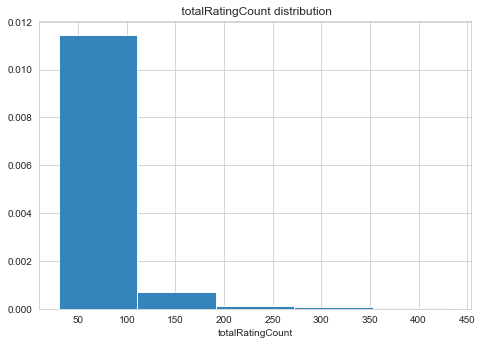

In [8]:

import scipy.stats as st


ratingCount = (rating_df.
     groupby(by = ['item'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['item', 'totalRatingCount']]
    )
data = ratingCount.loc[:, 'totalRatingCount'].values


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    data,
    alpha=0.9,
    bins=5,
    density=True,
    cumulative=False
)


plt.xlabel('totalRatingCount')
plt.title(' totalRatingCount distribution')
plt.show()

### Prepare data set

In [9]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(rating_df[['userId','item','rating']], reader)
trainset, testset = train_test_split(data, random_state=0, test_size=0.25)

In [10]:
fullTrainSet = data.build_full_trainset()

# Define recommender metrics

In [11]:

from collections import defaultdict
def getPopularityBasedOnRatingCount(top_n=None):
    ratings = defaultdict(int)
    rankings = defaultdict(int)
    with open('RAW_interactions.csv', newline='', encoding="utf8") as csvfile:
        ratingReader = csv.reader(csvfile)
        next(ratingReader)
        for row in ratingReader:
            ids = int(row[1])
            #increse rating count for that movie
            ratings[ids] += 1
    rank = 1
    for ids, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
        rankings[ids] = rank
        rank += 1
    if top_n is None:
        return rankings
    else:
        return sorted(rankings, key=rankings.get, reverse=False)[:top_n]
    

### Rating Prediction

In [12]:
from surprise import accuracy
from collections import defaultdict
def MAE(predictions):
    return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
    return accuracy.rmse(predictions, verbose=False)

### TOP N predictions

In [13]:
def Get_Top_Predictions(predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for uid, bid, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(uid)].append((int(bid), estimatedRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings[:n]
    return topN

In [14]:
def Get_data_from_Testset(predictions):
    topN = defaultdict(list)
    for uid, bid, actualRating, estimatedRating, _ in predictions:
        topN[int(uid)].append((int(bid), estimatedRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings
    return topN

In [15]:
def Get_Top_Predictions_In_Actual_DataSet(predictions, n=10, minimumRating=0.0):
    topN = defaultdict(list)
    for uid, mid, actualRating in predictions:
        if (actualRating >= minimumRating):
            topN[int(uid)].append((int(mid), actualRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings[:n]
    return topN

In [16]:
def Get_All_Predictions_In_Actual_DataSet(predictions ):
    topN = defaultdict(list)
    for uid, mid, actualRating in predictions:
        topN[int(uid)].append((int(mid), actualRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings
    return topN

###  See how often we recommended a movie the user actually rated

In [17]:
def MAP_K(topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
        hit=0
        total=0
        predictions=[]
        actual_predictions=[]
        for book,_ in topNPredicted[int(userid)]:
            predictions.append(book)
        for book,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(book)
            
        for i in predictions:
            total+=1
            if i in actual_predictions:
                hit+=1
        
        if(total==0):
            totalhit_ratio=0
        else:
            totalhit_ratio+=(hit/total)  
       
    return (totalhit_ratio/totalcount)

In [18]:
def HitRate(topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    hit=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
        
        
        predictions=[]
        actual_predictions=[]
        for book,_ in topNPredicted[int(userid)]:
            predictions.append(book)
        for book,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(book) 
        for i in predictions:
            if i in actual_predictions:
                hit+=1
                break
        
        
    
    return (hit/totalcount)

### Percentage of users have at least one "good" recommendation

In [19]:

def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
    hits = 0
    for userID in topNPredicted.keys():
        hit = 0
        for mid, predictedRating in topNPredicted[userID]:
            if (predictedRating >= ratingThreshold):
                hit = 1
                break
        if (hit==1):
            hits += 1
    return hits / numUsers

### Novelty is a measure of how popular the items system recommending.

In [20]:
def Novelty(topNPredicted, rankings):
    n = 0
    total = 0
    for uid in topNPredicted.keys():
        for rating in topNPredicted[uid]:
            mid = rating[0]
            rank = rankings[mid]
            total += rank
            n += 1
    if n==0:
        return 0
    return total / n

### Evaluation metrics

In [21]:
from surprise.model_selection import LeaveOneOut
import itertools


In [22]:

class Evaluate:
    def __init__(self, algo):
        self.algo = algo
    def start(self, n=10, verbose=True):
        before=datetime.now() 
        #trainSet, testSet = train_test_split(data, test_size=.25, random_state=1)
        algo.fit(trainset)
        after= datetime.now() 
        duration = after-before                         
        duration = duration.total_seconds() 
        print('time taken '+str(duration)+'s')
        predictions = algo.test(testset)
        rmse= RMSE(predictions)
        mae= MAE(predictions)
        print("Computing RMSE "+str(rmse))
        print("Computing MAE "+str(mae))
        return duration,rmse,mae
    
   
    def getModel(self):
        return self.algo
    def OtherMetrics(self):
            
            self.algo.fit(fullTrainSet)
            bigTestSet = fullTrainSet.build_anti_testset()
            all_pred = algo.test(bigTestSet)
            topN= Get_Top_Predictions(all_pred, n=10)

            
            ranking=getPopularityBasedOnRatingCount()
            # Print user coverage:
            user_coverage= UserCoverage(topN, fullTrainSet.n_users, ratingThreshold=4.0)
            print("\nUser coverage: ",user_coverage)
            # Measure novelty (average popularity rank of recommendations):
            novelty=Novelty(topN, ranking)
            print("\nNovelty : ",novelty )
            # Measure diversity of recommendations:

            #diversity=Diversity(topN, simsAlgo)
            #print("\nDiversity: ", diversity)
          
            return novelty,user_coverage
        
   
    def RecommendationMetricsOnwholeTestSet(self):
        hit_rate=0
        cumm_hit_rate=0
        print("Computing recommendations with train and test dataset...")
        # Build predictions for all ratings  in the test set
        print("Predict ratings...")
        allPredictions = algo.test(testset)
     
        # Compute top 10 recs for each user
        print("Compute top 10 recs per user")
        topNPredicted = Get_Top_Predictions(allPredictions)
        allPredictedOnActualDataSet = Get_All_Predictions_In_Actual_DataSet(testset)
        topNPredictedOnActualDataSet =   Get_Top_Predictions_In_Actual_DataSet(testset)
       
      
        #Calculate hit rate
        
        hit_rate=HitRate(topNPredicted, allPredictedOnActualDataSet)
        print("\nHit Rate: ",hit_rate )

        map_k= MAP_K(topNPredicted, allPredictedOnActualDataSet)
        print("\nMAP@K: ",map_k )
        
        
         #Calculate hit rate
        
        hit_rate_most_liked=HitRate(topNPredicted, topNPredictedOnActualDataSet)
        print("\nHit Rate on top liked items: ",hit_rate_most_liked )

        map_k_most_liked= MAP_K(topNPredicted, topNPredictedOnActualDataSet)
        print("\nMAP@K  on top liked items: ",map_k_most_liked )
        # See how often we recommended a movie the user actually liked
       
          
        return hit_rate,map_k
    

In [35]:

from surprise import SVD
from datetime import datetime
algo =  SVD(n_epochs = 500, lr_all = 0.0001, n_factors = 50)
evaluate=Evaluate(algo)
svd_duration,svd_rmse,svd_mae=evaluate.start()


time taken 96.124737s
Computing RMSE 0.8190013695927739
Computing MAE 0.4724166130391703


In [24]:
svd_hit_rate,svd_map_k=evaluate.RecommendationMetricsOnwholeTestSet()
svd_novelty,svd_user_coverage=evaluate.OtherMetrics()
algosvd=evaluate.getModel()

Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  0.9992172211350293

MAP@K:  0.44031311154598823

Hit Rate on top liked items:  0.9972602739726028

MAP@K  on top liked items:  0.4356120895846923

User coverage:  1.0

Novelty :  846.9699447431302


### SVD++

In [36]:

from surprise import SVDpp
from datetime import datetime
algo =  SVDpp()
evaluate=Evaluate(algo)
algosvdpp = SVDpp(n_epochs = 500, lr_all = 0.0001, n_factors = 50)
evaluate=Evaluate(algosvdpp)
svdpp_duration,svdpp_rmse,svdpp_mae=evaluate.start()
svdpp_hit_rate,svdpp_map_k=evaluate.RecommendationMetricsOnwholeTestSet()
svdpp_novelty,svdpp_user_coverage=evaluate.OtherMetrics()
algosvdpp=evaluate.getModel()

time taken 69.124597s
Computing RMSE 0.8256946610788903
Computing MAE 0.4684112785644732
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  0.9816046966731898

MAP@K:  0.02426614481409002

Hit Rate on top liked items:  0.9808219178082191

MAP@K  on top liked items:  0.02426614481409002

User coverage:  0.9958955223880597

Novelty :  1127.3675454408892


### NMF

In [29]:

from surprise import NMF
from datetime import datetime
algo =  SVDpp()
evaluate=Evaluate(algo)
algoNMF = NMF()
evaluate=Evaluate(algoNMF)
NMF_duration,NMF_rmse,NMF_mae=evaluate.start()
NMF_hit_rate,NMF_mapk=evaluate.RecommendationMetricsOnwholeTestSet()

algoNMF=evaluate.getModel()

time taken 99.691693s
Computing RMSE 0.8253969477349904
Computing MAE 0.46787908664693806
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  0.9804305283757339

MAP@K:  0.02426614481409002

Hit Rate on top liked items:  0.9796477495107632

MAP@K  on top liked items:  0.02426614481409002


# Neighbourhood based method

### User-Based recommendation

In [30]:
from surprise import KNNBasic
print("\nComputing item similarities ...")
options = {'name': 'cosine', 'user_based': True}
simsAlgo = KNNBasic(sim_options=options)
simsAlgo.fit(fullTrainSet)
simsMatrix = simsAlgo.compute_similarities()


Computing item similarities ...
Computing the cosine similarity matrix...


C:\ProgramData\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [31]:
import heapq
from operator import itemgetter
def getdataForAllUsers(n=10, verbose=True):
        print("\nComputing  similarities ...")
        options = {'name': 'cosine', 'user_based': True}
        
        simsAlgo = KNNBasic(sim_options=options)
        simsAlgo.fit(trainset)
        simsMatrix = simsAlgo.compute_similarities()
        
        topN = defaultdict(list)
        
        hit_rate=0
        cumm_hit_rate=0
        k = 10
        
        for uid in range(trainset.n_users):
            # Get top N similar users to this one
            similarityRow = simsMatrix[uid]
            
            similarUsers = []
            for innerID, score in enumerate(similarityRow):
                if (innerID != uid):
                    similarUsers.append( (innerID, score) )
            
            kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
            
            # Get the stuff they rated, and add up ratings for each item, weighted by user similarity
            candidates = defaultdict(float)
            for similarUser in kNeighbors:
                innerID = similarUser[0]
                userSimilarityScore = similarUser[1]
                theirRatings = trainset.ur[innerID]
                for rating in theirRatings:
                    candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore
                
            # Build a dictionary of stuff the user has already seen
            alreadyRead = {}
            for itemID, rating in trainset.ur[uid]:
                alreadyRead[itemID] = 1
                
            # Get top-rated items from similar users:
            pos = 0
            for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
                if not itemID in alreadyRead:
                    id = trainset.to_raw_iid(itemID)
                    topN[int(trainset.to_raw_uid(uid))].append( (int(id), 0.0) )
                    pos += 1
                    if (pos > n):
                        break
                        
        return topN

In [32]:
topN=getdataForAllUsers()
allPredictedOnActualDataSet = Get_All_Predictions_In_Actual_DataSet(testset)



Computing  similarities ...
Computing the cosine similarity matrix...


C:\ProgramData\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
hit_rate_knn=HitRate(topN,allPredictedOnActualDataSet)
hit_rate_knn

0.12915851272015655